# 自动标注

本节及后面几节探讨以不同的方式给文本自动添加词性标记。首先加载将要使用的数据：

In [1]:
from nltk.corpus import brown
brown_tagged_sents = brown.tagged_sents(categories='news')
brown_sents = brown.sents(categories='news')

## 默认标注器

最简单的标注器是为每个标识符分配同样的标记，这一步可以建立标注器性能的一个重要的底线。为了得到最好的效果，我们用最可能的标记标注每个词：

In [2]:
import nltk
tags = [tag for (word, tag) in brown.tagged_words(categories='news')]
print(nltk.FreqDist(tags).max())

NN


现在我们可以创建一个将所有词都标注成 NN 的标注器 [nltk.DefaultTagger](https://www.nltk.org/_modules/nltk/tag/sequential.html#DefaultTagger)：

In [3]:
raw = 'I do not like green eggs and ham, I do not like them Sam I am!'
tokens = nltk.word_tokenize(raw)
default_tagger = nltk.DefaultTagger('NN')
print(default_tagger.tag(tokens))

[('I', 'NN'), ('do', 'NN'), ('not', 'NN'), ('like', 'NN'), ('green', 'NN'), ('eggs', 'NN'), ('and', 'NN'), ('ham', 'NN'), (',', 'NN'), ('I', 'NN'), ('do', 'NN'), ('not', 'NN'), ('like', 'NN'), ('them', 'NN'), ('Sam', 'NN'), ('I', 'NN'), ('am', 'NN'), ('!', 'NN')]


In [4]:
print(default_tagger.evaluate(brown_tagged_sents))

0.13089484257215028


可以看出这种方法的表现相当不好，在一个典型的语料库中只正确标注了八分之一的标识符。但是默认标注器可以处理之前从未遇到过的词，帮助提高语言处理系统的稳定性。

## 正则表达式

正则表达式标注器 [nltk.RegexpTagger](https://www.nltk.org/_modules/nltk/tag/sequential.html#RegexpTagger) 基于匹配模式分配标记给标识符。

In [5]:
patterns = [
    (r'.*ing$', 'VBG'),
    (r'.*ed$', 'VBD'),
    (r'.*es$', 'VBZ'),
    (r'.*ould$', 'MD'),
    (r'.*\'s$', 'NN$'),
    (r'.*s$', 'NNS'),
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'),
    (r'.*', 'NN')
]
regexp_tagger = nltk.RegexpTagger(patterns)
print(regexp_tagger.tag(brown_sents[3]))
print(regexp_tagger.evaluate(brown_tagged_sents))

[('``', 'NN'), ('Only', 'NN'), ('a', 'NN'), ('relative', 'NN'), ('handful', 'NN'), ('of', 'NN'), ('such', 'NN'), ('reports', 'NNS'), ('was', 'NNS'), ('received', 'VBD'), ("''", 'NN'), (',', 'NN'), ('the', 'NN'), ('jury', 'NN'), ('said', 'NN'), (',', 'NN'), ('``', 'NN'), ('considering', 'VBG'), ('the', 'NN'), ('widespread', 'NN'), ('interest', 'NN'), ('in', 'NN'), ('the', 'NN'), ('election', 'NN'), (',', 'NN'), ('the', 'NN'), ('number', 'NN'), ('of', 'NN'), ('voters', 'NNS'), ('and', 'NN'), ('the', 'NN'), ('size', 'NN'), ('of', 'NN'), ('this', 'NNS'), ('city', 'NN'), ("''", 'NN'), ('.', 'NN')]
0.20326391789486245


注意这些匹配模式是顺序处理的，第一个匹配上的标志会被使用。最终的正则表达式 .* 是一个全面捕捉，标注所有词为名词。可以看出正则表达式标注器将准确率提高到了五分之一。

## 查询标注器

很多高频词并不是名词 NN，我们可以找出 100 个最频繁的词，存储它们最有可能的标记，然后使用这个信息作为“查找标注器（[nltk.UnigramTagger](https://www.nltk.org/_modules/nltk/tag/sequential.html#UnigramTagger)）”的模型:

In [6]:
fd = nltk.FreqDist(brown.words(categories='news'))
cfd = nltk.ConditionalFreqDist(brown.tagged_words(categories='news'))
most_freq_words = fd.most_common(100)
likely_tags = dict((word, cfd[word].max()) for (word, _) in most_freq_words)
baseline_tagger = nltk.UnigramTagger(model=likely_tags)
print(baseline_tagger.tag(brown_sents[3]))
print(baseline_tagger.evaluate(brown_tagged_sents))

[('``', '``'), ('Only', None), ('a', 'AT'), ('relative', None), ('handful', None), ('of', 'IN'), ('such', None), ('reports', None), ('was', 'BEDZ'), ('received', None), ("''", "''"), (',', ','), ('the', 'AT'), ('jury', None), ('said', 'VBD'), (',', ','), ('``', '``'), ('considering', None), ('the', 'AT'), ('widespread', None), ('interest', None), ('in', 'IN'), ('the', 'AT'), ('election', None), (',', ','), ('the', 'AT'), ('number', None), ('of', 'IN'), ('voters', None), ('and', 'CC'), ('the', 'AT'), ('size', None), ('of', 'IN'), ('this', 'DT'), ('city', None), ("''", "''"), ('.', '.')]
0.45578495136941344


可以看出仅仅知道 100 个最频繁的词的标记就使我们能正确标注很大一部分标识符。同时许多词都被分配了一个 None 标签，因此它们不在最频繁的词中。在这些情况下，我们希望首先使用查询标注器，如果它不能指定一个标记就使用默认标注器，这个过程叫做**回退（backoff）**。我们可以通过指定一个标注器作为另一个标注器的参数来实现：

In [7]:
baseline_tagger = nltk.UnigramTagger(model=likely_tags, backoff=nltk.DefaultTagger('NN'))
print(baseline_tagger.evaluate(brown_tagged_sents))

0.5817769556656125


标注准确率又得到了进一步的提高。

接下来，我们来看看不同大小的模型对查询标注器性能的影响：

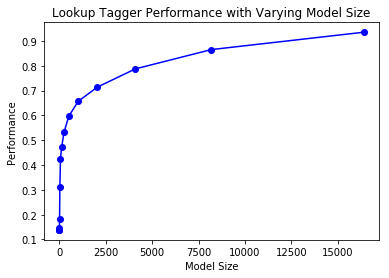

In [9]:
def performance(cfd, wordlist):
    lt = dict((word, cfd[word].max()) for word in wordlist)
    baseline_tagger = nltk.UnigramTagger(model=lt, backoff=nltk.DefaultTagger('NN'))
    return baseline_tagger.evaluate(brown.tagged_sents(categories='news'))

def display():
    import pylab
    words_by_freq = list(nltk.FreqDist(brown.words(categories='news')))
    cfd = nltk.ConditionalFreqDist(brown.tagged_words(categories='news'))
    sizes = 2 ** pylab.arange(15)
    perfs = [performance(cfd, words_by_freq[:size]) for size in sizes]
    pylab.plot(sizes, perfs, '-bo')
    pylab.title('Lookup Tagger Performance with Varying Model Size')
    pylab.xlabel('Model Size')
    pylab.ylabel('Performance')
    pylab.show()
    
display()

观察上图，随着模型规模的增长，最初的性能增加迅速，最终达到一个稳定水平，这时模型的规模大量增加性能的提高很小。

## 评估

工具的性能评估是 NLP 的一种中心主题，一个模块输出中的任何错误都会在下游模块大大的放大。由于我们通常很难获得专业和公正的人的判断，所以使用**黄金标准**测试数据来代替。这是一个已经手动标注并作为自动系统评估标准而被接受的语料库。当标注器对给定词猜测的标记与黄金标准标记相同，标注器被视为是正确的。